# Figure 1
## Measures of Heatwave Hazard with Trends

In [4]:
import xarray
from distributed import Client
import numpy as np
import cftime
import matplotlib.pyplot as plt


client = Client('localhost:8786')
client

<Client: 'tcp://146.6.192.149:8786' processes=10 threads=10>

In [117]:
hw_mn_all

<xarray.Dataset> Size: 6GB
Dimensions:     (member: 20, percentile: 2, year: 181, lat: 192, lon: 288)
Coordinates:
  * lat         (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon         (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * percentile  (percentile) float64 16B 0.9 0.95
  * year        (year) int64 1kB 1920 1921 1922 1923 ... 2097 2098 2099 2100
Dimensions without coordinates: member
Data variables:
    HWD         (member, percentile, year, lat, lon) int64 3GB dask.array<chunksize=(1, 2, 181, 96, 72), meta=np.ndarray>
    HWF         (member, percentile, year, lat, lon) int64 3GB dask.array<chunksize=(1, 2, 181, 96, 72), meta=np.ndarray>
Attributes:
    date_prepared:    2024-03-26 17:04:40.819111
    description:      Heatwave metrics.
    dev_affiliation:  Persad Aero-Climate Lab, Department of Earth and Planet...
    dev_email:        cameron.cummins@utexas.edu
    dev_name:         Cameron Cummins

In [60]:
HW_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/LENS1/HEAT_OUTPUTS/"

land_mask_path = "/projects/dgs/persad_research/SIMULATION_DATA/DATA/LENS1/CESM1/all/001/day/LANDFRAC/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.200001-209912.nc"
land_mask = xarray.open_dataset(land_mask_path)["LANDFRAC"].mean(dim="time")

hw_mn_all_path = f"{HW_DIR}CESM1_LE_all_TREFHTMN_HW_METRICS.zarr"
hw_mn_xaer_path = f"{HW_DIR}CESM1_LE_xaer_TREFHTMN_HW_METRICS.zarr"
hw_mn_xghg_path = f"{HW_DIR}CESM1_LE_xghg_TREFHTMN_HW_METRICS.zarr"
OUTPUT_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/MERRA2/HEAT_OUTPUTS/"
hw_mn_merra_path = f"{OUTPUT_DIR}MERRA2_T2MMIN_HW_METRICS.zarr"


hw_mn_all = xarray.open_zarr(hw_mn_all_path)
hw_mn_xaer = xarray.open_zarr(hw_mn_xaer_path)
hw_mn_xghg = xarray.open_zarr(hw_mn_xghg_path)
hw_mn_merra = xarray.open_zarr(hw_mn_merra_path)


hw_mn_all_ts = hw_mn_all.sel(percentile=0.9).where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mn_all.lat))).mean(dim=["lat", "lon"]).compute()
hw_mn_xaer_ts = hw_mn_xaer.sel(percentile=0.9).where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mn_xaer.lat))).mean(dim=["lat", "lon"]).compute()
hw_mn_xghg_ts = hw_mn_xghg.sel(percentile=0.9).where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mn_xghg.lat))).mean(dim=["lat", "lon"]).compute()
hw_mn_merra_ts = hw_mn_merra.sel(percentile=0.9).where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mn_merra.lat))).mean(dim=["lat", "lon"]).compute()

Text(0, 0.5, 'Heatwave Frequency (Heatwave Days per Year)')

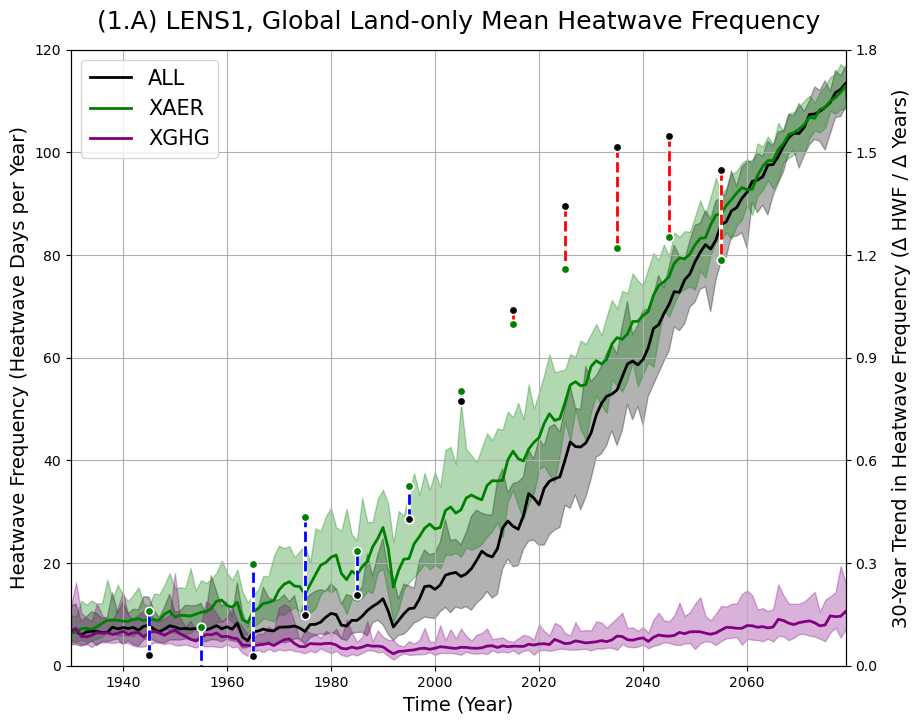

In [116]:
all_color = "Black"
xaer_color = "Green"
xghg_color = "Purple"

regression_centers = np.arange(1945, 2065, 10)
all_regressions = np.zeros((2, regression_centers.size))
xaer_regressions = np.zeros((2, regression_centers.size))

for index, center in enumerate(regression_centers):
    hw_mn_all_ts_slice = hw_mn_all_ts["HWF"].sel(year=slice(center-15, center+14)).mean(dim="member")
    hw_mn_xaer_ts_slice = hw_mn_xaer_ts["HWF"].sel(year=slice(center-15, center+14)).mean(dim="member")

    all_regressions[:, index] = np.polyfit(hw_mn_all_ts_slice.year.values, hw_mn_all_ts_slice.values, 1)
    xaer_regressions[:, index] = np.polyfit(hw_mn_xaer_ts_slice.year.values, hw_mn_xaer_ts_slice.values, 1)

f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

hw_mn_all_ts["HWF"].mean(dim="member").plot(ax=ax1, color=all_color, linewidth=2, label="ALL")
#hw_mn_merra_ts["HWF"].sel(year=slice(1980,2023)).plot(ax=ax1, color=all_color, linewidth=2, label="MERRA2", linestyle="--")
hw_mn_xaer_ts["HWF"].mean(dim="member").plot(ax=ax1, color=xaer_color, linewidth=2, label="XAER")
hw_mn_xghg_ts["HWF"].mean(dim="member").plot(ax=ax1, color=xghg_color, linewidth=2, label="XGHG")

a = 0.3
ax1.fill_between(hw_mn_all_ts["HWF"].year.values, hw_mn_all_ts["HWF"].min(dim="member"), hw_mn_all_ts["HWF"].max("member"), alpha=a, color=all_color)
ax1.fill_between(hw_mn_xaer_ts["HWF"].year.values, hw_mn_xaer_ts["HWF"].min(dim="member"), hw_mn_xaer_ts["HWF"].max("member"), alpha=a, color=xaer_color)
ax1.fill_between(hw_mn_xghg_ts["HWF"].year.values, hw_mn_xghg_ts["HWF"].min(dim="member"), hw_mn_xghg_ts["HWF"].max("member"), alpha=a, color=xghg_color)

ax11 = ax1.twinx()

for index, center in enumerate(regression_centers):
    all_val = all_regressions[0, index]
    xaer_val = xaer_regressions[0, index]
    color = "Blue"
    if all_val > xaer_val:
        color = "Red"

    ax11.plot([center, center], [all_val,  xaer_val], linewidth=3, linestyle="-", color="White", zorder=0)
    ax11.plot([center, center], [all_val,  xaer_val], linewidth=2, linestyle="--", color=color, zorder=5)

s = 40
ax11.scatter(regression_centers, all_regressions[0, :], color="White", s=s, zorder=10)
ax11.scatter(regression_centers, xaer_regressions[0, :], color="White", s=s, zorder=10)

s = 15
ax11.scatter(regression_centers, all_regressions[0, :], color=all_color, s=s, zorder=15)
ax11.scatter(regression_centers, xaer_regressions[0, :], color=xaer_color, s=s, zorder=15)

ax11.set_yticks(np.arange(0, 2, 0.3))
ax11.set_ylim(0, 1.8)
ax11.set_ylabel("30-Year Trend in Heatwave Frequency (Δ HWF / Δ Years)", fontsize=14, labelpad=10)

ax1.grid(zorder=-10)
ax1.legend(fontsize=15)
ax1.set_xlim(1930, 2079)
ax1.set_ylim(0, 120)
ax1.set_title("(1.A) LENS1, Global Land-only Mean Heatwave Frequency", fontsize=18, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Heatwave Frequency (Heatwave Days per Year)", fontsize=14)

Text(0, 0.5, 'Δ Heatwave Frequency (Δ Heatwave Days per Year)')

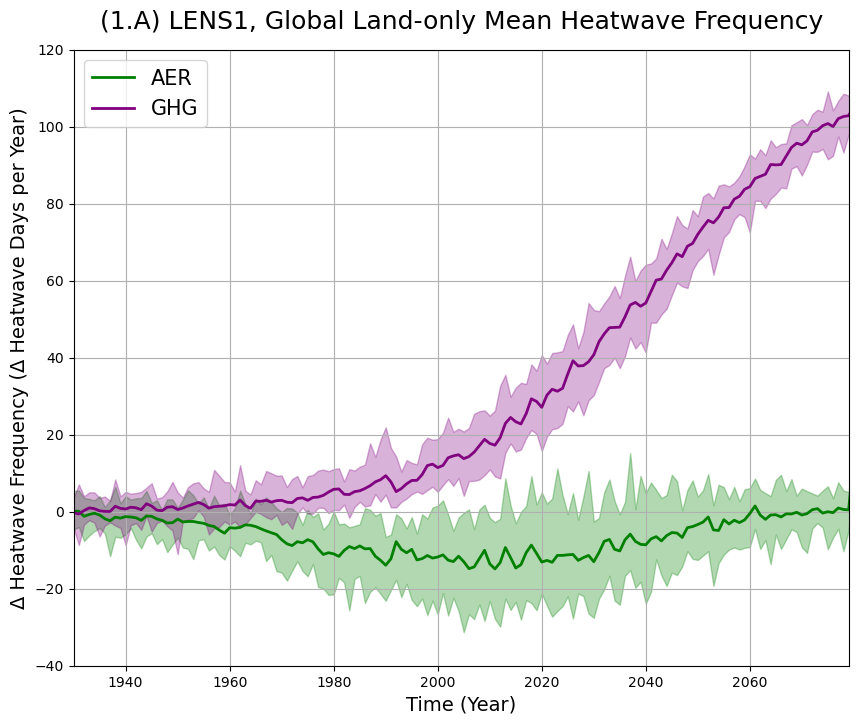

In [105]:
all_color = "Black"
xaer_color = "Green"
xghg_color = "Purple"

f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

hw_mn_aer_ts = hw_mn_all_ts["HWF"] - hw_mn_xaer_ts["HWF"]
hw_mn_ghg_ts = hw_mn_all_ts["HWF"] - hw_mn_xghg_ts["HWF"]

hw_mn_aer_ts.mean(dim="member").plot(ax=ax1, color=xaer_color, linewidth=2, label="AER")
hw_mn_ghg_ts.mean(dim="member").plot(ax=ax1, color=xghg_color, linewidth=2, label="GHG")

a = 0.3
ax1.fill_between(hw_mn_aer_ts.year.values, hw_mn_aer_ts.min(dim="member"), hw_mn_aer_ts.max("member"), alpha=a, color=xaer_color)
ax1.fill_between(hw_mn_aer_ts.year.values, hw_mn_ghg_ts.min(dim="member"), hw_mn_ghg_ts.max("member"), alpha=a, color=xghg_color)


ax1.grid(zorder=-10)
ax1.legend(fontsize=15)
ax1.set_xlim(1930, 2079)
ax1.set_ylim(-40, 120)
ax1.set_title("(1.A) LENS1, Global Land-only Mean Heatwave Frequency", fontsize=18, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Δ Heatwave Frequency (Δ Heatwave Days per Year)", fontsize=14)

Text(0, 0.5, 'Heatwave Duration (Heatwave Days per Year)')

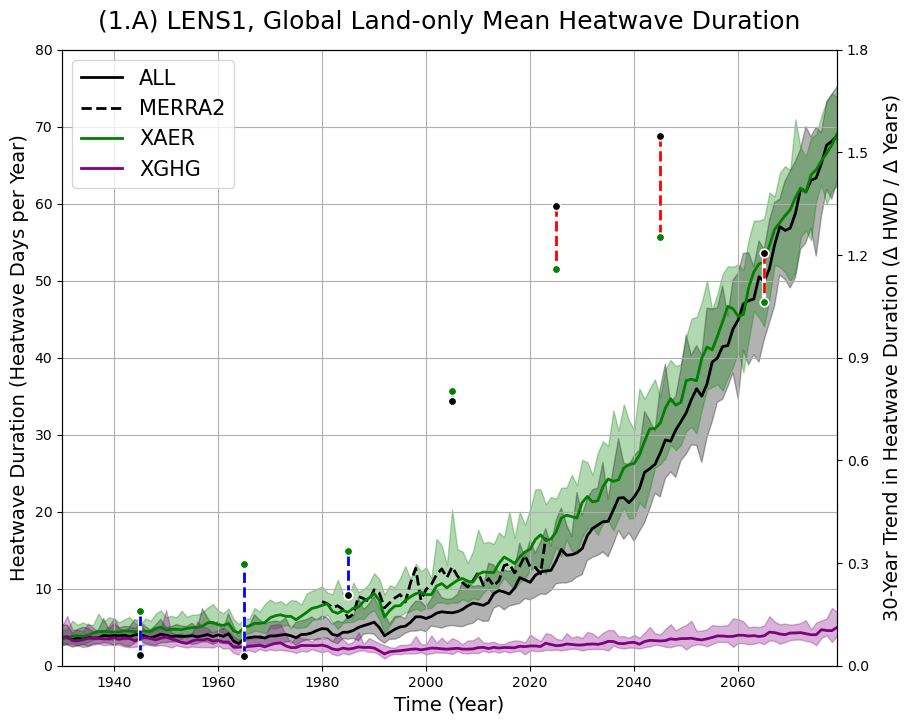

In [99]:
all_color = "Black"
xaer_color = "Green"
xghg_color = "Purple"

f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

hw_mn_all_ts["HWD"].mean(dim="member").plot(ax=ax1, color=all_color, linewidth=2, label="ALL")
hw_mn_merra_ts["HWD"].sel(year=slice(1980,2023)).plot(ax=ax1, color=all_color, linewidth=2, label="MERRA2", linestyle="--")
hw_mn_xaer_ts["HWD"].mean(dim="member").plot(ax=ax1, color=xaer_color, linewidth=2, label="XAER")
hw_mn_xghg_ts["HWD"].mean(dim="member").plot(ax=ax1, color=xghg_color, linewidth=2, label="XGHG")

a = 0.3
ax1.fill_between(hw_mn_all_ts["HWD"].year.values, hw_mn_all_ts["HWD"].min(dim="member"), hw_mn_all_ts["HWD"].max("member"), alpha=a, color=all_color)
ax1.fill_between(hw_mn_xaer_ts["HWD"].year.values, hw_mn_xaer_ts["HWD"].min(dim="member"), hw_mn_xaer_ts["HWD"].max("member"), alpha=a, color=xaer_color)
ax1.fill_between(hw_mn_xghg_ts["HWD"].year.values, hw_mn_xghg_ts["HWD"].min(dim="member"), hw_mn_xghg_ts["HWD"].max("member"), alpha=a, color=xghg_color)

ax11 = ax1.twinx()

for index, center in enumerate(regression_centers):
    all_val = all_regressions[0, index]
    xaer_val = xaer_regressions[0, index]
    color = "Blue"
    if all_val > xaer_val:
        color = "Red"

    ax11.plot([center, center], [all_val,  xaer_val], linewidth=3, linestyle="-", color="White", zorder=0)
    ax11.plot([center, center], [all_val,  xaer_val], linewidth=2, linestyle="--", color=color, zorder=5)

s = 40
ax11.scatter(regression_centers, all_regressions[0, :], color="White", s=s, zorder=10)
ax11.scatter(regression_centers, xaer_regressions[0, :], color="White", s=s, zorder=10)

s = 15
ax11.scatter(regression_centers, all_regressions[0, :], color=all_color, s=s, zorder=15)
ax11.scatter(regression_centers, xaer_regressions[0, :], color=xaer_color, s=s, zorder=15)

ax11.set_yticks(np.arange(0, 2, 0.3))
ax11.set_ylim(0, 1.8)
ax11.set_ylabel("30-Year Trend in Heatwave Duration (Δ HWD / Δ Years)", fontsize=14, labelpad=10)

ax1.grid(zorder=-10)
ax1.legend(fontsize=15)
ax1.set_xlim(1930, 2079)
ax1.set_ylim(0, 80)
ax1.set_title("(1.A) LENS1, Global Land-only Mean Heatwave Duration", fontsize=18, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Heatwave Duration (Heatwave Days per Year)", fontsize=14)

In [94]:
INPUT_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/LENS1/SIM_VARIABLES/"
tmin_all_path = f"{INPUT_DIR}all_day_TREFHTMN.zarr"
tmin_xaer_path = f"{INPUT_DIR}xaer_day_TREFHTMN.zarr"
tmin_xghg_path = f"{INPUT_DIR}xghg_day_TREFHTMN.zarr"

tmin_all_ds = xarray.open_zarr(tmin_all_path)["TREFHTMN"] - 273.15
tmin_xaer_ds = xarray.open_zarr(tmin_xaer_path)["TREFHTMN"] - 273.15
tmin_xghg_ds = xarray.open_zarr(tmin_xghg_path)["TREFHTMN"] - 273.15
INPUT_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/MERRA2/SIM_VARIABLES/"
tmin_merra2_ds = xarray.open_zarr(f"{INPUT_DIR}MERRA2_day_T2MMIN.zarr")["T2MMIN"] - 273.15

time_cftime = []
days_to_drop = np.zeros(tmin_merra2_ds.time.size, dtype=bool)
for index, date in enumerate(tmin_merra2_ds.time.values):
    year, month, day_stuff = str(date).split("-")
    day, hour_stuff = day_stuff.split("T")
    hour = hour_stuff.split(":")[0]
    try:
        timestamp = cftime.datetime(int(year), int(month), int(day), int(hour), calendar="noleap")
        time_cftime.append(timestamp)
    except ValueError:
        days_to_drop[index] = True

calendar_mask = xarray.DataArray(
    data=days_to_drop,
    coords=dict(time=tmin_merra2_ds.time.values)
)
tmin_merra2_ds = tmin_merra2_ds.where(calendar_mask - 1, drop=True).convert_calendar("noleap")

tmin_all_ts = tmin_all_ds.weighted(np.cos(np.deg2rad(tmin_all_ds.lat))).mean(dim=["lat", "lon"]).resample(time="YE").mean().compute()
tmin_xaer_ts = tmin_xaer_ds.weighted(np.cos(np.deg2rad(tmin_xaer_ds.lat))).mean(dim=["lat", "lon"]).resample(time="YE").mean().compute()
tmin_xghg_ts = tmin_xghg_ds.weighted(np.cos(np.deg2rad(tmin_xghg_ds.lat))).mean(dim=["lat", "lon"]).resample(time="YE").mean().compute()
tmin_merra2_ts = tmin_merra2_ds.weighted(np.cos(np.deg2rad(tmin_merra2_ds.lat))).mean(dim=["lat", "lon"]).resample(time="YE").mean().compute()

/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/xarray/core/indexing.py:1430: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/xarray/core/indexing.py:1430: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  retur

Text(0, 0.5, 'Daily Minimum Temperature (°C)')

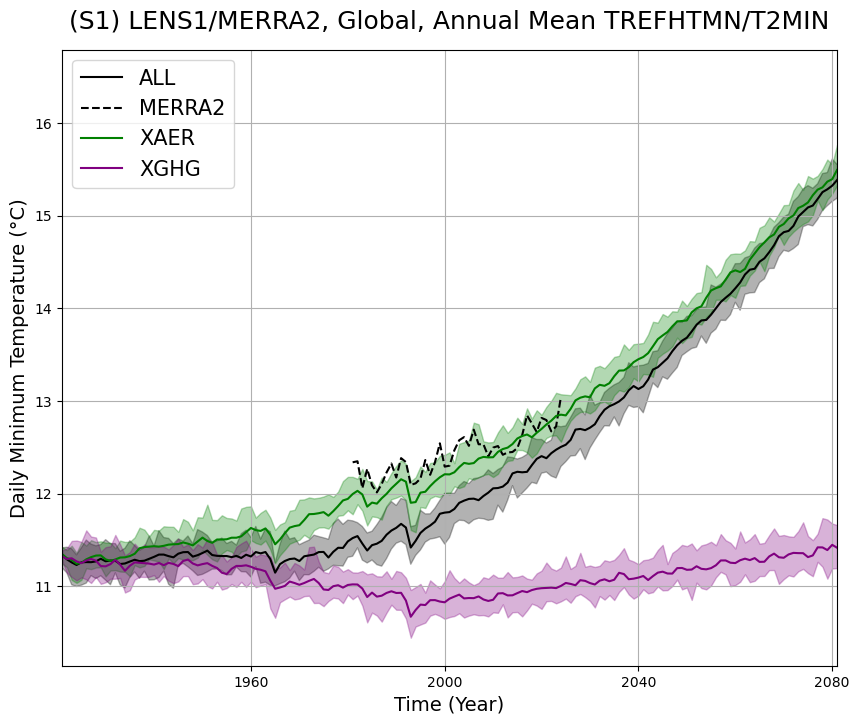

In [107]:
f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

tmin_all_ts.mean(dim="member").plot(ax=ax1, color="Black", label="ALL")
tmin_merra2_ts.sel(time=slice(tmin_merra2_ts.time[0], tmin_merra2_ts.time[-2])).plot(ax=ax1, color="Black", linestyle="--", label="MERRA2")
tmin_xaer_ts.mean(dim="member").plot(ax=ax1, color="Green", label="XAER")
tmin_xghg_ts.mean(dim="member").plot(ax=ax1, color="Purple", label="XGHG")

ax1.fill_between(tmin_all_ts.time.values, tmin_all_ts.min(dim="member"), tmin_all_ts.max("member"), alpha=a, color=all_color)
ax1.fill_between(tmin_xaer_ts.time.values, tmin_xaer_ts.min(dim="member"), tmin_xaer_ts.max("member"), alpha=a, color=xaer_color)
ax1.fill_between(tmin_xghg_ts.time.values, tmin_xghg_ts.min(dim="member"),tmin_xghg_ts.max("member"), alpha=a, color=xghg_color)


ax1.set_xlim(tmin_xaer_ts.time.values[0], tmin_xaer_ts.time.values[-1])

ax1.grid(zorder=-10)
ax1.legend(fontsize=15)
ax1.set_title("(S1) LENS1/MERRA2, Global, Annual Mean TREFHTMN/T2MIN", fontsize=18, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Daily Minimum Temperature (°C)", fontsize=14)